# Extra Credit

In [2]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install keras
!pip install tensorflow-gpu
!pip install git+https://github.com/tensorflow/docs
!pip install h5py

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-l7kn1p9f
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-l7kn1p9f
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=82418 sha256=ed9a8cd75e6538944c909eb3abd5cff55589c66cc6309576905badb06ea85a67
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ytb69q7/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random

In [0]:
# Baseline Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [7]:
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
import tensorflow as tf

Using TensorFlow backend.


In [0]:
train_path = "/content/drive/My Drive/extra_data/ExtraCredit_Train.csv"
test_path = "/content/drive/My Drive/extra_data/ExtraCredit_Test.csv"

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Prepare Data

In [0]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [9]:
train_df.head(10)

,file_name,annotation,hours,air_temperature,humidity,pressure,zonal_wind_speed,meridional_wind_speed,longwave_radiation,convective_precipitation,potential_energy,potential_evaporation,precipitation,shortwave_radiation
0,000006.jpg,0,7.000000,24.84,0.017546,99748.1,2.90,3.28,401.18,0.0000,602.624,0.0265,0.0000,216.280
1,000016.jpg,0,11.516667,32.42,0.018943,99356.9,3.08,2.50,458.45,0.0000,2086.400,0.8650,0.0000,791.133
2,000032.jpg,0,20.016667,30.20,0.019103,99171.1,1.07,3.52,434.54,0.0000,1760.380,0.0595,0.0000,0.000
3,000097.jpg,4,10.800000,25.54,0.012345,100449.0,1.28,-0.53,401.86,0.0000,0.000,0.3351,0.0000,619.795
4,000104.jpg,0,8.750000,26.60,0.017723,99751.7,3.33,2.98,401.19,0.0000,1033.020,0.4682,0.0000,387.584
5,000253.jpg,0,14.516667,32.91,0.017613,99656.7,2.87,2.80,454.22,0.7959,1876.030,0.7130,0.0024,640.389
6,000265.jpg,0,13.016667,34.09,0.018228,99317.2,2.56,2.35,482.65,0.0000,2074.370,0.8650,0.0000,638.059
7,000306.jpg,2,16.516667,34.17,0.018813,99124.5,2.29,4.29,466.48,0.8583,2224.130,0.7068,4.9264,332.363
8,000339.jpg,2,18.516667,29.12,0.016459,99529.0,-3.71,-0.92,421.53,0.0000,1073.540,0.3178,0.0000,125.552
9,000353.jpg,0,19.016667,31.30,0.019413,99170.6,1.00,3.21,434.54,0.0000,1866.750,0.2569,0.0000,6.000


In [0]:
test_df.head(10)

,file_name,annotation,hours,air_temperature,humidity,pressure,zonal_wind_speed,meridional_wind_speed,longwave_radiation,convective_precipitation,potential_energy,potential_evaporation,precipitation,shortwave_radiation
0,011749.jpg,2,13.516667,31.97,0.016097,99566.3,-4.48,-1.42,424.76,0.0000,955.20,0.8838,0.0000,821.036
1,011755.jpg,2,13.266667,31.97,0.016097,99566.3,-4.48,-1.42,424.76,0.0000,955.20,0.8838,0.0000,821.036
2,012394.jpg,2,12.516667,33.25,0.018585,99336.8,2.82,2.42,458.45,0.0000,2080.38,0.8650,0.0000,847.412
3,012529.jpg,4,18.616667,22.95,0.009803,100149.0,-3.86,-2.02,370.23,0.0000,0.00,0.2569,0.0000,56.960
4,012803.jpg,4,10.850000,22.74,0.011119,100076.0,-4.30,-2.21,411.48,0.0000,0.00,0.2739,0.0000,375.196
5,012970.jpg,2,14.516667,31.99,0.016089,99551.1,-4.33,-1.63,424.76,0.0000,1053.25,0.8302,0.0000,738.858
6,013123.jpg,2,16.766667,34.17,0.018813,99124.5,2.29,4.29,466.48,0.8583,2224.13,0.7068,4.9264,332.363
7,013490.jpg,2,12.266667,30.98,0.016237,99655.6,-3.74,-2.04,417.26,0.0000,963.20,0.8838,0.0000,849.472
8,013563.jpg,4,13.866667,25.51,0.009827,100233.0,-3.02,-3.36,393.45,0.0000,0.00,0.5555,0.0000,649.180
9,013751.jpg,3,19.516667,31.30,0.019413,99170.6,1.00,3.21,434.54,0.0000,1866.75,0.2569,0.0000,6.000


In [0]:
file_to_ann_train = {}
file_to_ann_test = {}
file_to_X_train = {}
file_to_X_test = {}
X_train = []
X_test = []
y_train = []
y_test = []
for index, row in train_df.iterrows():
    file_to_ann_train[row['file_name']] = row['annotation']
    file_to_X_train[row['file_name']] = np.array(row['hours':])
    X_train.append(np.array(row['hours':]))
    y_train.append(row['annotation'])
for index, row in test_df.iterrows():
    file_to_ann_test[row['file_name']] = row['annotation']
    file_to_X_test[row['file_name']] = np.array(row['hours':])
    X_test.append(np.array(row['hours':]))
    y_test.append(row['annotation'])
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

## Baseline Analysis

In [0]:
model_dict = {
    "Logistic Regression": LogisticRegression(),
    "LDA": LinearDiscriminantAnalysis(),
    "1 Nearest Neighbors": KNeighborsClassifier(1),
    "2 Nearest Neighbors": KNeighborsClassifier(2),
    "3 Nearest Neighbors": KNeighborsClassifier(3),
    "5 Nearest Neighbors": KNeighborsClassifier(5),
    "7 Nearest Neighbors": KNeighborsClassifier(7),
    "10 Nearest Neighbors": KNeighborsClassifier(10),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "SVM-RBF": SVC(kernel="rbf"),
    "SVM-Linear": SVC(kernel="linear"),
    "Neural Network (12)": MLPClassifier(alpha=1e-3, hidden_layer_sizes=(12), max_iter=1000),
    "Neural Network (10)": MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10), max_iter=1000),
    "Neural Network (12, 6)": MLPClassifier(alpha=1e-3, hidden_layer_sizes=(12, 6), max_iter=1000),
    "Neural Network (12, 10)": MLPClassifier(alpha=1e-3, hidden_layer_sizes=(12, 10), max_iter=1000),
    "Neural Network (5)": MLPClassifier(alpha=1e-3, hidden_layer_sizes=(5), max_iter=1000),
    "Gaussian Process": GaussianProcessClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "AdaBoost": AdaBoostClassifier()
}

In [0]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(620, 12) (620,)
(100, 12) (100,)


### Standardize Data

In [0]:
standardizer = StandardScaler()
standardizer.fit(X_train)
mu, sigma = standardizer.mean_, standardizer.var_
X_train_st = standardizer.transform(X_train)
X_test_st = standardizer.transform(X_test)

### Classification Reports by Model

In [0]:
target_names = ['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4']
dictionary = dict(zip([0, 1, 2, 3, 4], target_names))
# Iterate through the models in the dictionary and perform baseline classification
print('-' * 75)
for key in model_dict.keys():
    model = model_dict[key]
    model.fit(X_train_st, y_train)
    y_hat_test = model.predict(X_test_st)
    report = classification_report(y_true=y_test, y_pred=y_hat_test, target_names=target_names)
    print("Model:", key)
    confusion = pd.DataFrame(confusion_matrix(y_test, y_hat_test))
    confusion.rename(columns=dictionary, index=dictionary, inplace=True)
    print(confusion, '\n')
    print(report)
    print('-'*75, '\n')

---------------------------------------------------------------------------
Model: Logistic Regression
        Crop 0  Crop 1  Crop 2  Crop 3  Crop 4
Crop 0      17       3       0       0       0
Crop 1       0      15       0       0       5
Crop 2      13       7       0       0       0
Crop 3      12       8       0       0       0
Crop 4       6       0       0       0      14 

              precision    recall  f1-score   support

      Crop 0       0.35      0.85      0.50        20
      Crop 1       0.45      0.75      0.57        20
      Crop 2       0.00      0.00      0.00        20
      Crop 3       0.00      0.00      0.00        20
      Crop 4       0.74      0.70      0.72        20

    accuracy                           0.46       100
   macro avg       0.31      0.46      0.36       100
weighted avg       0.31      0.46      0.36       100

--------------------------------------------------------------------------- 

Model: LDA
        Crop 0  Crop 1  Crop 2  Cro

/home/jeremy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jeremy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Neural Network (12)
        Crop 0  Crop 1  Crop 2  Crop 3  Crop 4
Crop 0      16       4       0       0       0
Crop 1       0      17       0       0       3
Crop 2       6       4       9       1       0
Crop 3      11       0       1       8       0
Crop 4       6       3       0       0      11 

              precision    recall  f1-score   support

      Crop 0       0.41      0.80      0.54        20
      Crop 1       0.61      0.85      0.71        20
      Crop 2       0.90      0.45      0.60        20
      Crop 3       0.89      0.40      0.55        20
      Crop 4       0.79      0.55      0.65        20

    accuracy                           0.61       100
   macro avg       0.72      0.61      0.61       100
weighted avg       0.72      0.61      0.61       100

--------------------------------------------------------------------------- 



/home/jeremy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jeremy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Neural Network (10)
        Crop 0  Crop 1  Crop 2  Crop 3  Crop 4
Crop 0      19       1       0       0       0
Crop 1       0      17       0       0       3
Crop 2       6       7       7       0       0
Crop 3      11       7       1       0       1
Crop 4       6       3       0       0      11 

              precision    recall  f1-score   support

      Crop 0       0.45      0.95      0.61        20
      Crop 1       0.49      0.85      0.62        20
      Crop 2       0.88      0.35      0.50        20
      Crop 3       0.00      0.00      0.00        20
      Crop 4       0.73      0.55      0.63        20

    accuracy                           0.54       100
   macro avg       0.51      0.54      0.47       100
weighted avg       0.51      0.54      0.47       100

--------------------------------------------------------------------------- 

Model: Neural Network (12, 6)
        Crop 0  Crop 1  Crop 2  Crop 3  Crop 4
Crop 0      17       3       0       0       

## Baseline Highlights
### Validation Accuracy
* 5 Nearest Neighbors: 64%
* 7 Nearest Neighbors: 63%
* 10 Nearest Neighbors: 64%
* Decision Tree: 64%
* SVM-RBF: 63%
* SVM-Linear: 62%
* Neural Network (12): 63%
* Neural Network (12, 6): 62%
* Gaussian Process: 65%


## Weather-Only Model

In [0]:
y_train_one_hot = y_train.reshape(-1, 1)
y_test_one_hot = y_test.reshape(-1, 1)
enc = OneHotEncoder()
y_train_one_hot = enc.fit_transform(y_train_one_hot)
y_test_one_hot = enc.fit_transform(y_test_one_hot)

In [0]:
# Hyperparameters
num_hidden_layers = [1, 2, 3, 4, 5]
num_epochs = [5, 10, 25, 50]
lr_rate = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
clipnorms = [0.5, 1.0]

---------------------------------------------------------------------------
Tuning Hyperparameters...
Neurons: 7
Neurons: 5
Optimizing with ADAM
Learning Rate: 1e-05
Hidden Layers: 2
Epochs: 10
Clip Norm: 1.0

test accuracy: 0.20000000298023224
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Tuning Hyperparameters...
Neurons: 5
Neurons: 5
Neurons: 5
Neurons: 5
Optimizing with RMSProp
Learning Rate: 1e-05
Hidden Layers: 4
Epochs: 25
Clip Norm: 1.0

test accuracy: 0.20000000298023224
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Tuning Hyperparameters...
Neurons: 10
Neurons: 8
Neurons: 5
Neurons: 5
Neurons: 5
Optimizing with RMSProp
Learning Rate: 0.0001
Hidden Layers: 5
Epochs: 50
Clip Norm: 1.0

test accuracy: 0.20000000298023224
--------------------------------------------------

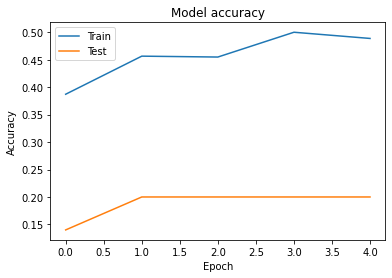

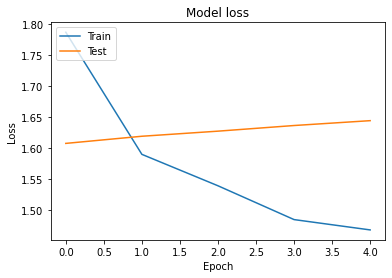

In [15]:
# Build the model
max_test_accuracy = 0
max_layers = None
max_neurons = None
max_lr = None
max_clipnorm = None
max_epochs = None
max_optimizer = None
max_history = None
max_model = None
max_optimizer_name = None
for _ in range(50):
    print('-'*75)
    print("Tuning Hyperparameters...")
    layers = random.choice(num_hidden_layers)
    input_vector = Input((X_train[0].shape))
    layer = input_vector
    prev_neurons = X_train[0].shape[0]
    layer_count = 0
    the_neurons = []
    for _ in range(layers):
        neurons = random.choice(list(range(y_train_one_hot[0].shape[1], prev_neurons+1)))
        layer = Dense(neurons)(layer)  # input is previous layer
        the_neurons.append(neurons)
        if layer_count == 0:
            layer = Dropout(0.1)(layer)
        else:
            layer = Dropout(0.5)(layer)
        layer = Activation('relu')(layer)
        prev_neurons = neurons
        layer_count += 1
        print("Neurons:", neurons)
    output_vector = Dense(y_train_one_hot[0].shape[1], activation='softmax')(layer)
    model = Model(inputs=[input_vector], outputs=[output_vector])
#     model.summary()

    # Compile the model
    lr = random.choice(lr_rate)
    clipnorm = random.choice(clipnorms)
    epochs = random.choice(num_epochs)
    optimizers = [keras.optimizers.SGD(lr=lr, clipnorm=clipnorm),
                 keras.optimizers.Adam(lr=lr, clipnorm=clipnorm),
                 keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
                 keras.optimizers.Adagrad(learning_rate=lr),
                 keras.optimizers.Adadelta(learning_rate=lr, rho=0.95)]
    keys = ["Stochastic Gradient Descent", "ADAM", "RMSProp", "AdaGrad", "AdaDelta"]
    optimizer = random.choice(optimizers)
    index = optimizers.index(optimizer)
    optimizer_name = keys[index]
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    print("Optimizing with", optimizer_name)
    print("Learning Rate:", lr)
    print("Hidden Layers:", layers)
    print("Epochs:", epochs)
    print("Clip Norm:", clipnorm)
    history = model.fit(x=X_train_st,
                        y=y_train_one_hot,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(X_test_st, y_test_one_hot))
    test_predictions = [pred.argmax(axis=-1) for pred in model.predict(X_test)]
    test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=0)[1]
    print("\ntest accuracy:", test_accuracy)
    print('-'*75)
    if test_accuracy > max_test_accuracy:
        max_test_accuracy = test_accuracy
        max_layers = layers
        max_neurons = the_neurons  # a list
        max_lr = lr
        max_clipnorm = clipnorm
        max_epochs = epochs
        max_optimizer = optimizer
        max_model = model
        max_history = history
        max_optimizer_name = optimizer_name

print('\n\n')
print("Maximally-tuned Hyperparameters:")
print("Optimizer", optimizer_name)
print("Learning Rate:", lr)
print("The Neurons:", the_neurons)
print("Hidden Layers:", max_layers)
print("Epochs:", max_epochs)
print("Clip Norm:", max_clipnorm)
print("Maximum Test Accuracy:", max_test_accuracy)
print('\n\n')

# Plot training & test accuracy values of the maximally-tuned model
plt.plot(max_history.history['accuracy'])
plt.plot(max_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & test loss values
plt.plot(max_history.history['loss'])
plt.plot(max_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Image Only Model

In [0]:
def get_image_model(n1, n2, dropout):
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg_model.trainable = False

    model = tf.keras.models.Sequential([
        vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n1, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(n2, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model
image_model = get_image_model(1024, 128, 0.5)
# image_model.load_weights("/content/drive/My Drive/weights/image_only_model.h5")

In [16]:
image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6

### Generate and Cache Image Patches

In [0]:
from PIL import Image
import cv2

In [0]:
train_filenames = list(train_df['file_name'])
test_filenames = list(test_df['file_name'])

In [0]:
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)

def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]
    print(images)   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


In [20]:
print("Saving extra credit images to corresponding directories...")
TRAIN_DATA_DIR = "/content/drive/My Drive/data/TrainData-C2/"
train_save_dir = "/content/drive/My Drive/extra_data/train_images/"
test_save_dir = "/content/drive/My Drive/extra_data/test_images/"
if not os.path.isdir(train_save_dir):
  for filename in train_filenames:
    img = cv2.imread(TRAIN_DATA_DIR + filename)
    cv2.imwrite(train_save_dir + filename, img)
if not os.path.isdir(test_save_dir):
  for filename in test_filenames:
    img = cv2.imread(TRAIN_DATA_DIR + filename)
    cv2.imwrite(test_save_dir + filename, img)
print("Complete.")

Saving extra credit images to corresponding directories...
Complete.


In [21]:
TRAIN_PATCHES_DATA_DIR = "/content/drive/My Drive/patches/train/"
TEST_PATCHES_DATA_DIR = "/content/drive/My Drive/patches/test/"
PATCH_ROWS = 5
PATCH_COLUMNS = 5
# train patches
if os.path.exists(TRAIN_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_PATCHES_DATA_DIR))
else:
    print("Generating train data patches...")
    generate_patch_files(train_save_dir, TRAIN_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

# test patches
if os.path.exists(TEST_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TEST_PATCHES_DATA_DIR))
else:
    print("Generating test data patches...")
    generate_patch_files(test_save_dir, TEST_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

/content/drive/My Drive/patches/train/ exists. Skipping.
/content/drive/My Drive/patches/test/ exists. Skipping.


In [0]:
import os
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
patch_filename_to_ann_train = dict.fromkeys(os.listdir(TRAIN_PATCHES_DATA_DIR))
patch_filename_to_ann_test = dict.fromkeys(os.listdir(TEST_PATCHES_DATA_DIR))
for key in patch_filename_to_ann_train.keys():
  patch_filename_to_ann_train[key] = [key, str(file_to_ann_train[key[:key.index('_')] + '.jpg'])]
for key in patch_filename_to_ann_test.keys():
  patch_filename_to_ann_test[key] = [key, str(file_to_ann_test[key[:key.index('_')] + '.jpg'])]
image_train_df = pd.DataFrame.from_dict(patch_filename_to_ann_train, orient='index', columns=['filename', 'annotation'])
image_test_df = pd.DataFrame.from_dict(patch_filename_to_ann_test, orient='index', columns=['filename', 'annotation'])

In [24]:
BATCH_SIZE = 32
train_generator = datagen.flow_from_dataframe(
  dataframe=image_train_df,
  directory=TRAIN_PATCHES_DATA_DIR,
  x_col="filename",
  y_col="annotation",
  subset="training",
  batch_size=BATCH_SIZE,
  seed=42,
  shuffle=True,
  class_mode="sparse",
  target_size=(224,224))

test_generator = datagen.flow_from_dataframe(
  dataframe=image_test_df,
  directory=TEST_PATCHES_DATA_DIR,
  x_col="filename",
  y_col="annotation",
  batch_size=BATCH_SIZE,
  shuffle=False,
  class_mode="sparse",
  target_size=(224,224))

Found 15500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [0]:
image_only_model = get_image_model(1024, 128, 0.5)
image_history = image_only_model.fit_generator(generator=train_generator,
                      steps_per_epoch=int(image_train_df.shape[0] / BATCH_SIZE),
                      epochs=10,
                      verbose=1,
                      validation_data=test_generator,
                      validation_steps=int(image_test_df.shape[0] / BATCH_SIZE))

In [0]:
# Trained on a separate machine
image_only_model = get_image_model(1024, 128, 0.5)
image_only_model.load_weights("/content/drive/My Drive/weights/image_only_model.h5")

In [0]:
train_preds = image_only_model.predict(train_generator)
test_preds = image_only_model.predict(test_generator)

In [0]:
print(classification_report(y_true=image_train_df['annotation'].tolist(), y_pred=train_preds, target_names=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4']))

In [0]:
print(classification_report(y_true=image_test_df['annotation'].tolist(), y_pred=test_preds, target_names=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4']))

In [0]:
from scipy import stats
# Each test image is split into 25 patches
# Get the votes
num_patches = 25
true_test_predictions = []
true_y_test = []
for i in range(0, len(test_preds), num_patches):
    crop_preds = test_preds[i:i+num_patches]
    top_vote = stats.mode(crop_preds)[0][0]
    true_test_predictions.append(top_vote)
    true_y_test.append(image_test_df['annotation'].tolist()[i])
true_y_test = np.array(true_y_test)

In [0]:
report = classification_report(y_true=true_y_test, y_pred=true_test_predictions, target_names=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4'])
print(report)

In [0]:
pd.DataFrame(confusion_matrix(y_true=true_y_test, y_pred=true_test_predictions))

## Fuse Models

In [0]:
import pickle
if not os.path.isfile('/content/drive/My Drive/patches/train_patches.p'):
  image_X_train = np.zeros((len(os.listdir(TRAIN_PATCHES_DATA_DIR)), 5))
  i = 0
  for filename in os.listdir(TRAIN_PATCHES_DATA_DIR):
    pred = np.ravel(image_only_model.predict(cv2.imread(TRAIN_PATCHES_DATA_DIR + filename).reshape([-1, 224, 224, 3])))
    if i % 200 == 0:
      print("Patch", str(i) + '/' + str(len(os.listdir(TRAIN_PATCHES_DATA_DIR))), '\t' + str(pred.shape))
    image_X_train[i] = pred
    i += 1
else:
  image_X_train = pickle.load(open('/content/drive/My Drive/patches/train_patches.p', 'rb'))
print("Done.")

Patch 0/15500 	(5,)
Patch 200/15500 	(5,)
Patch 400/15500 	(5,)
Patch 600/15500 	(5,)
Patch 800/15500 	(5,)
Patch 1000/15500 	(5,)
Patch 1200/15500 	(5,)
Patch 1400/15500 	(5,)
Patch 1600/15500 	(5,)
Patch 1800/15500 	(5,)
Patch 2000/15500 	(5,)
Patch 2200/15500 	(5,)
Patch 2400/15500 	(5,)
Patch 2600/15500 	(5,)
Patch 2800/15500 	(5,)
Patch 3000/15500 	(5,)
Patch 3200/15500 	(5,)
Patch 3400/15500 	(5,)
Patch 3600/15500 	(5,)
Patch 3800/15500 	(5,)
Patch 4000/15500 	(5,)
Patch 4200/15500 	(5,)
Patch 4400/15500 	(5,)
Patch 4600/15500 	(5,)
Patch 4800/15500 	(5,)
Patch 5000/15500 	(5,)
Patch 5200/15500 	(5,)
Patch 5400/15500 	(5,)
Patch 5600/15500 	(5,)
Patch 5800/15500 	(5,)
Patch 6000/15500 	(5,)
Patch 6200/15500 	(5,)
Patch 6400/15500 	(5,)
Patch 6600/15500 	(5,)
Patch 6800/15500 	(5,)
Patch 7000/15500 	(5,)
Patch 7200/15500 	(5,)
Patch 7400/15500 	(5,)
Patch 7600/15500 	(5,)
Patch 7800/15500 	(5,)
Patch 8000/15500 	(5,)
Patch 8200/15500 	(5,)
Patch 8400/15500 	(5,)
Patch 8600/15500 	

In [0]:
if not os.path.isfile('/content/drive/My Drive/patches/test_patches.p'):
  image_X_test = np.zeros((len(os.listdir(TEST_PATCHES_DATA_DIR)), 5))
  i = 0
  for filename in os.listdir(TEST_PATCHES_DATA_DIR):
    pred = np.ravel(image_only_model.predict(cv2.imread(TEST_PATCHES_DATA_DIR + filename).reshape([-1, 224, 224, 3])))
    if i % 200 == 0:
      print("Patch", str(i) + '/' + str(len(os.listdir(TEST_PATCHES_DATA_DIR))), '\t' + str(pred.shape))
    image_X_test[i] = pred
    i += 1
  pickle.dump(image_X_test, open('/content/drive/My Drive/patches/test_patches.p', 'wb'))
else:
  image_X_test = pickle.load(open('/content/drive/My Drive/patches/test_patches.p', 'rb'))
print("Done.")

Patch 0/2500 	(5,)
Patch 200/2500 	(5,)
Patch 400/2500 	(5,)
Patch 600/2500 	(5,)
Patch 800/2500 	(5,)
Patch 1000/2500 	(5,)
Patch 1200/2500 	(5,)
Patch 1400/2500 	(5,)
Patch 1600/2500 	(5,)
Patch 1800/2500 	(5,)
Patch 2000/2500 	(5,)
Patch 2200/2500 	(5,)
Patch 2400/2500 	(5,)
Done.


In [0]:
weather_X_train = [file_to_X_train[filename[:filename.index('_')] + '.jpg'] for filename in os.listdir(TRAIN_PATCHES_DATA_DIR)]
weather_y_train = [file_to_ann_train[filename[:filename.index('_')] + '.jpg'] for filename in os.listdir(TRAIN_PATCHES_DATA_DIR)]
weather_X_test = [file_to_X_test[filename[:filename.index('_')] + '.jpg'] for filename in os.listdir(TEST_PATCHES_DATA_DIR)]
weather_y_test = [file_to_ann_test[filename[:filename.index('_')] + '.jpg'] for filename in os.listdir(TEST_PATCHES_DATA_DIR)]

In [0]:
final_X_train = []
final_X_test = []
print("Concatenating training data...")
for i in range(len(weather_X_train)):
  final_X_train.append(np.concatenate((image_X_train[i], weather_X_train[i]), axis=0))
print("Concatenating test data...")
for i in range(len(weather_X_test)):
  final_X_test.append(np.concatenate((image_X_test[i], weather_X_test[i]), axis=0))
final_X_train = np.array(final_X_train)
final_X_test = np.array(final_X_test)
print("Complete.")

Concatenating training data...
Concatenating test data...
Complete.


In [0]:
standardizer = StandardScaler()
print("Computing mean and variance...")
standardizer.fit(final_X_train)
mu, sigma = standardizer.mean_, standardizer.var_
print("Standardizing training data...")
final_X_train_st = standardizer.transform(final_X_train)
print("Standardizing test data...")
final_X_test_st = standardizer.transform(final_X_test)
print("Complete.")

Computing mean and variance...
Standardizing training data...
Standardizing test data...
Complete.


## Final Classifier

In [0]:
final_y_train_one_hot = np.array(weather_y_train).reshape(-1, 1)
final_y_test_one_hot = np.array(weather_y_test).reshape(-1, 1)
enc = OneHotEncoder()
final_y_train_one_hot = enc.fit_transform(final_y_train_one_hot)
final_y_test_one_hot = enc.fit_transform(final_y_test_one_hot)

In [0]:
final_input_vector = Input((final_X_train_st[0].shape))
hidden_layer = Dense(10, activation='relu')(final_input_vector)
final_output_vector = Dense(final_y_train_one_hot[0].shape[1], activation='softmax')(hidden_layer)
final_classifier = Model(inputs=[final_input_vector], outputs=[final_output_vector])

In [0]:
final_classifier.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, clipnorm=1.0), metrics=['accuracy'])

In [0]:
history = final_classifier.fit(x=final_X_train_st,
                      y=final_y_train_one_hot,
                      epochs=40,
                      verbose=1,
                      validation_data=(final_X_test_st, final_y_test_one_hot))

Train on 15500 samples, validate on 2500 samples
Epoch 1/40
15500/15500 [==============================] - 1s 90us/step - loss: 1.5145 - accuracy: 0.3259 - val_loss: 1.5275 - val_accuracy: 0.4372
Epoch 2/40
15500/15500 [==============================] - 1s 85us/step - loss: 1.1242 - accuracy: 0.6523 - val_loss: 1.5114 - val_accuracy: 0.4508
Epoch 3/40
15500/15500 [==============================] - 1s 84us/step - loss: 0.9880 - accuracy: 0.6785 - val_loss: 1.4748 - val_accuracy: 0.4580
Epoch 4/40
15500/15500 [==============================] - 1s 85us/step - loss: 0.9157 - accuracy: 0.6923 - val_loss: 1.4189 - val_accuracy: 0.4732
Epoch 5/40
15500/15500 [==============================] - 1s 84us/step - loss: 0.8554 - accuracy: 0.6999 - val_loss: 1.3418 - val_accuracy: 0.4920
Epoch 6/40
15500/15500 [==============================] - 1s 82us/step - loss: 0.8031 - accuracy: 0.7063 - val_loss: 1.2778 - val_accuracy: 0.5092
Epoch 7/40
15500/15500 [==============================] - 1s 81us/ste

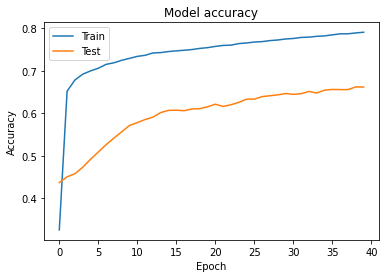

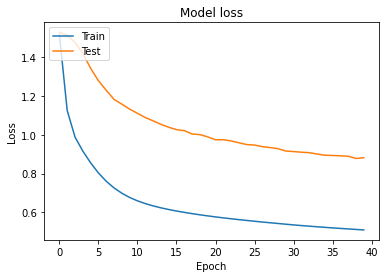

In [0]:
# Plot training & test accuracy values of the fused model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
test_predictions = [pred.argmax(axis=-1) for pred in final_classifier.predict(final_X_test_st)]
report = classification_report(y_true=np.array([np.argmax(label) for label in final_y_test_one_hot]), y_pred=test_predictions, target_names=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4'])
print(report)

              precision    recall  f1-score   support

      Crop 0       0.63      0.87      0.73       500
      Crop 1       0.62      0.97      0.75       500
      Crop 2       0.67      0.35      0.46       500
      Crop 3       0.60      0.48      0.54       500
      Crop 4       0.87      0.64      0.74       500

    accuracy                           0.66      2500
   macro avg       0.68      0.66      0.64      2500
weighted avg       0.68      0.66      0.64      2500



In [0]:
pd.DataFrame(confusion_matrix(y_true=np.array([np.argmax(label) for label in final_y_test_one_hot]), y_pred=test_predictions))

,0,1,2,3,4
0,433,64,0,3,0
1,0,483,0,0,17
2,110,159,176,55,0
3,114,32,80,242,32
4,29,43,5,102,321


In [0]:
from scipy import stats

In [0]:
# Each test image is split into 25 patches
# Get the votes
num_patches = 25
true_test_predictions = []
true_y_test = []
for i in range(0, len(test_predictions), num_patches):
    crop_preds = test_predictions[i:i+num_patches]
    top_vote = stats.mode(crop_preds)[0][0]
    true_test_predictions.append(top_vote)
    true_y_test.append(np.array([np.argmax(label) for label in final_y_test_one_hot])[i])
true_y_test = np.array(true_y_test)

In [0]:
report = classification_report(y_true=true_y_test, y_pred=true_test_predictions, target_names=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4'])
print(report)

              precision    recall  f1-score   support

      Crop 0       0.30      0.52      0.38        25
      Crop 1       0.24      0.52      0.32        23
      Crop 2       0.00      0.00      0.00        16
      Crop 3       0.50      0.11      0.18        18
      Crop 4       0.00      0.00      0.00        18

    accuracy                           0.27       100
   macro avg       0.21      0.23      0.18       100
weighted avg       0.22      0.27      0.20       100



/home/jeremy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
pd.DataFrame(confusion_matrix(y_true=true_y_test, y_pred=true_test_predictions))

,0,1,2,3,4
0,13,10,0,2,0
1,11,12,0,0,0
2,8,8,0,0,0
3,6,9,0,2,1
4,6,12,0,0,0
